# Multiple Parameter Estimations
It is often desirable to run a single optimization problem many times. In copasi this is fairly easy using the `repeat` scan item. In Pycotools we can use the `MultipleParameterEstimation` class to the same end.   

## Pre-requisites
### Get the Demonstration model
-  Zi et al 2012

In [9]:
%matplotlib inline
import site
site.addsitedir('/home/b3053674/Documents/pycotools')
from pycotools import model, tasks, viz, misc
from pycotools.Models.zi_model_variants import Models
import os
import pandas
from lxml import etree

## get string model from test_models
zi_model_string = Models().published_zi

## get a working directory. Change this to change this to wherever you like
directory = r'/home/b3053674/Documents/Models/2017/10_Oct/TutorialWorkspace'

## choose path to zi model
zi_path = os.path.join(directory, 'zi2012.cps')

##write model to file
with open(zi_path, 'w') as f:
    f.write(zi_model_string)
    
## check file exists
if not os.path.isfile(zi_path):
    raise Exception
    
zi = model.Model(zi_path)

### Generate Synthetic Data

In [10]:
report= 'parameter_estimation_synthetic_data.txt'
TC=tasks.TimeCourse(
    zi, start=0, end=1000, intervals=10, step_size=100, report_name=report
)

## validate that its worked
pandas.read_csv(TC.report_name,sep='\t').head()

## informative name
zi_data_file = TC.report_name

### Format synthetic data 

In [11]:
misc.correct_copasi_timecourse_headers(zi_data_file)

,Time,Smad4n,Smad4c,Smad3n,Smad3c,T2R_Surf,T1R_EE,T1R_Cave,T1R_Surf,T2R_EE,...,Kcd,kr_Cave,ki_Cave,Kexp_Smad4n,Kdiss_Smads_Complex_n,Kimp_Smad2c,Kimp_Smads_Complex_c,Kimp_Smad4c,Kdeg_T2R_EE,k_Smads_Complex_c
0,0,551.720,1149.40,236.450,492.610,0.202000,2.060000,2.092000,0.237000,1.148000,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069
1,100,539.437,945.10,187.070,300.676,0.042480,0.153971,0.159964,0.005712,0.192643,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069
2,200,543.973,1020.66,205.334,371.659,0.090375,0.019241,0.019872,0.001432,0.476866,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069
3,300,545.077,1045.27,211.116,394.709,0.112896,0.009298,0.009471,0.000980,0.625865,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069
4,400,545.245,1049.48,212.097,398.651,0.122516,0.007748,0.007873,0.000869,0.690089,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069
5,500,545.270,1050.11,212.243,399.238,0.126573,0.007242,0.007356,0.000824,0.717217,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069
6,600,545.274,1050.21,212.265,399.329,0.128277,0.006983,0.007092,0.000798,0.728619,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069
7,700,545.274,1050.22,212.269,399.344,0.128991,0.006808,0.006915,0.000779,0.733399,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069
8,800,545.274,1050.22,212.269,399.345,0.129289,0.006669,0.006772,0.000764,0.735394,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069
9,900,545.274,1050.22,212.269,399.344,0.129412,0.006545,0.006647,0.000750,0.736221,...,0.005,0.03742,0.33,0.5,0.1174,0.16,0.16,0.08,0.025,0.000069


# The MultipleParameterEstimation Class
The MultipleParameterEstimation class is an interface to the ParameterEstimation class and accepts all of the same keyword parameters with a few extra:

    1. `copy_number`          --> Number of times to copy a copasi file. All of these will be run simultaneously. 
    2. `pe_number`            --> How many parameter estimations to conduct **per model**
    3. `results_directory`    --> Name of the directory to put the results (created if not exists)
    4. `max_active`           --> How many models to run simultaneously

The total number of estimations that can be carried out simultaneously is $copy\_number\cdot pe\_number$. 

In [14]:
MPE=tasks.MultiParameterEstimation(
    zi, zi_data_file, copy_number=10, pe_number=50, 
    metabolites=[], local_parameters=[], lower_bound=1e-3, upper_bound=5e3, 
    method='genetic_algorithm', population_size=10, number_of_generations=10,
    overwrite_config_file=True, run_mode='multiprocess'
)
    
MPE.write_config_file()
MPE.setup()
MPE.run()

pycotools.tasks:DEBUG:3812:    run mode --> multiprocess
pycotools.tasks:DEBUG:3813:    models --> [Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)]
pycotools.tasks:DEBU

In [13]:
zi.open()

All models are executed using CopasiSE at the same time. For this reason, if you have too many models running at once on a single machine, the machine will slow and be unusable until the estimations have finished. My Windows machine (i7, 16GB RAM) can comfortably run around 6 or 7 models at once before things start to slow. My Ubuntu machine can run more but the estimations are significantly slower. If using a SunGridEngine based job scheduler you can use `run = SGE` to submit the jobs automatically. If your using a different job scheduler it is straight forward to write another function within the `pycopi.Run` class to support your scheduler. Feel free to contact me for advice.   

## Custom Results Directory

In [5]:
MPE = tasks.MultiParameterEstimation(
    zi, zi_data_file, copy_number=4, pe_number=2)
MPE.write_config_file()
MPE.setup()
#MPE.run()

pycotools.tasks:DEBUG:3813:    run mode --> multiprocess
pycotools.tasks:DEBUG:3814:    models --> [Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)]
pycotools.tasks:DEBUG:3815:    len models --> 4
pycotools.tasks:DEBUG:495:    i be models --> [Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol), Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)]
pycotools.tasks:DEBUG:505:    self.models from run --> [Model(name=Zi2007_TGFbeta_signaling, time_uni

# Visualization
All visualization tools share a similar set of keyword arguments for saving figures or controlling where they get saved to. See the [documentation](http://pycotools.readthedocs.io/en/latest/APIDoc/viz/viz_index.html) for a table of these.

## Time course ensembles
These are useful for identifying model strengths and weaknesses. Time courses are calculated using parameter sets from parameter estimation data and averaged. Confidence intervals are calculated

pycotools.viz:INFO:1350:    Plotting "LRC_Cave"
pycotools.viz:INFO:1350:    Plotting "LRC_EE"
pycotools.viz:INFO:1350:    Plotting "LRC_Surf"
pycotools.viz:INFO:1350:    Plotting "Smad3c"
pycotools.viz:INFO:1350:    Plotting "Smad3n"
pycotools.viz:INFO:1350:    Plotting "Smad4c"
pycotools.viz:INFO:1350:    Plotting "Smad4n"
pycotools.viz:INFO:1350:    Plotting "Smads_Complex_c"
pycotools.viz:INFO:1350:    Plotting "Smads_Complex_n"
pycotools.viz:INFO:1350:    Plotting "T1R_Cave"
pycotools.viz:INFO:1350:    Plotting "T1R_EE"
pycotools.viz:INFO:1350:    Plotting "T1R_Surf"
pycotools.viz:INFO:1350:    Plotting "T2R_Cave"
pycotools.viz:INFO:1350:    Plotting "T2R_EE"
pycotools.viz:INFO:1350:    Plotting "T2R_Surf"
pycotools.viz:INFO:1350:    Plotting "TGF_beta"


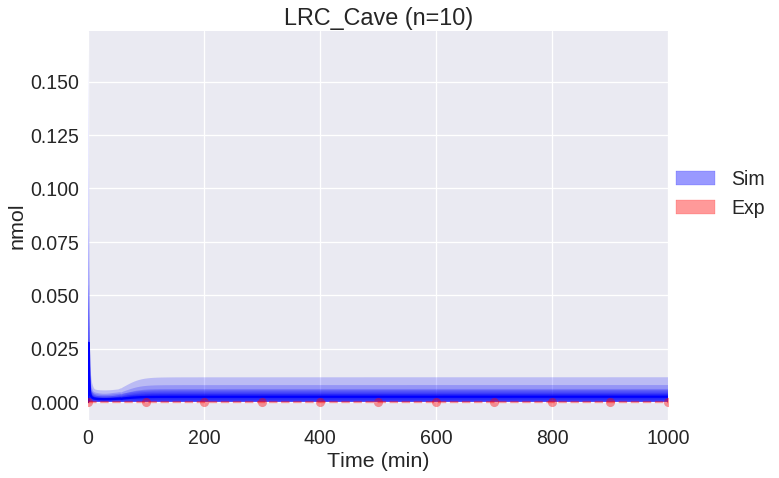

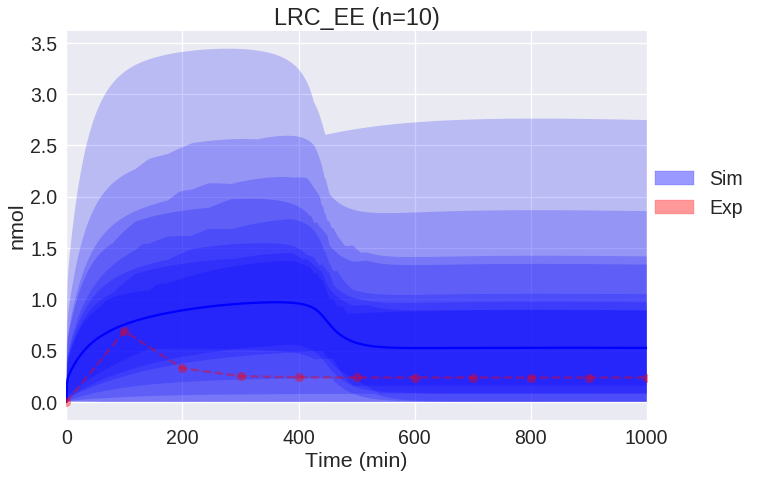

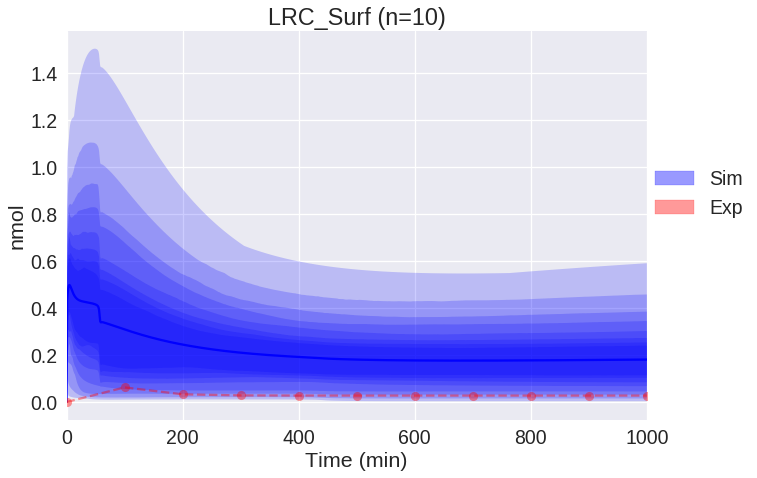

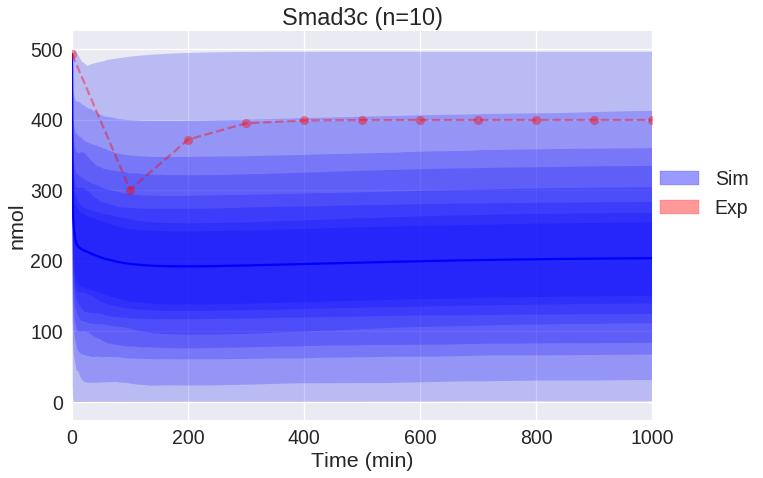

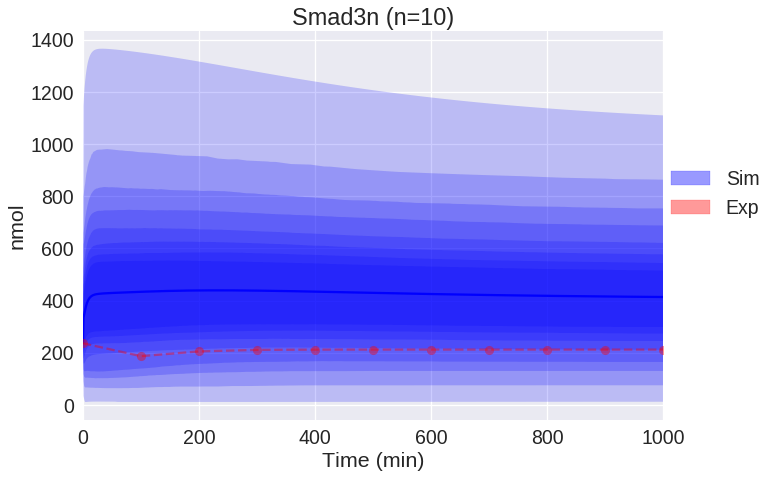

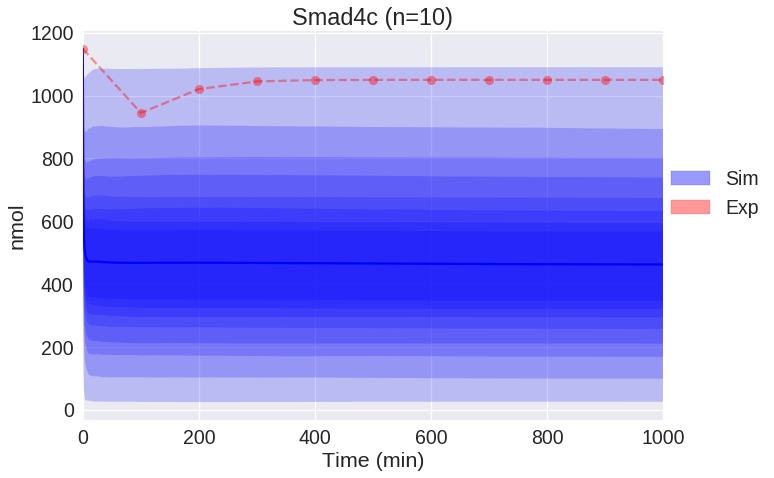

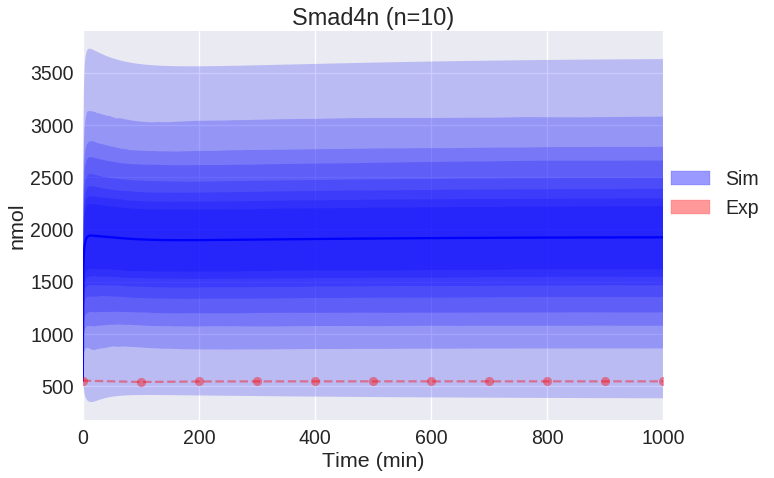

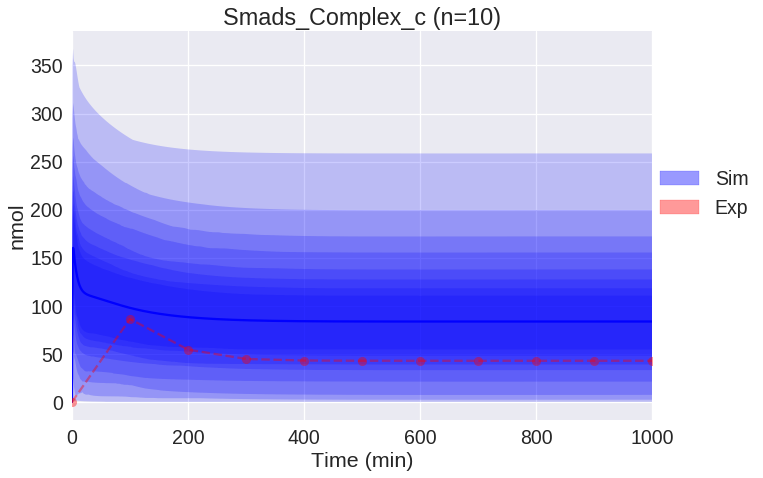

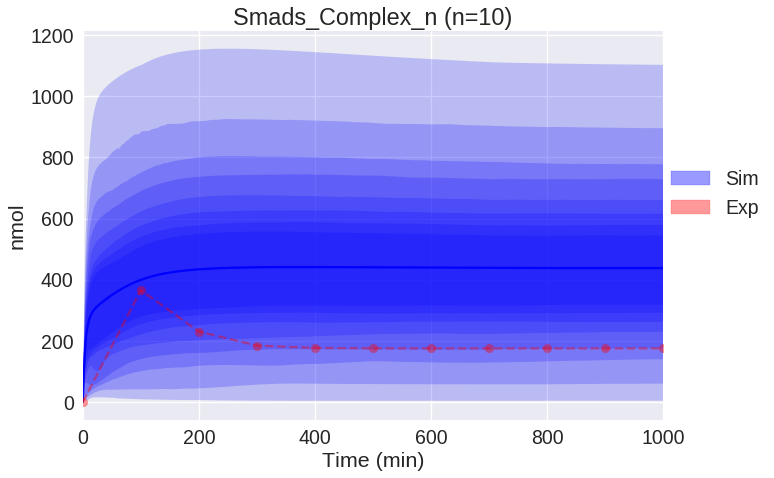

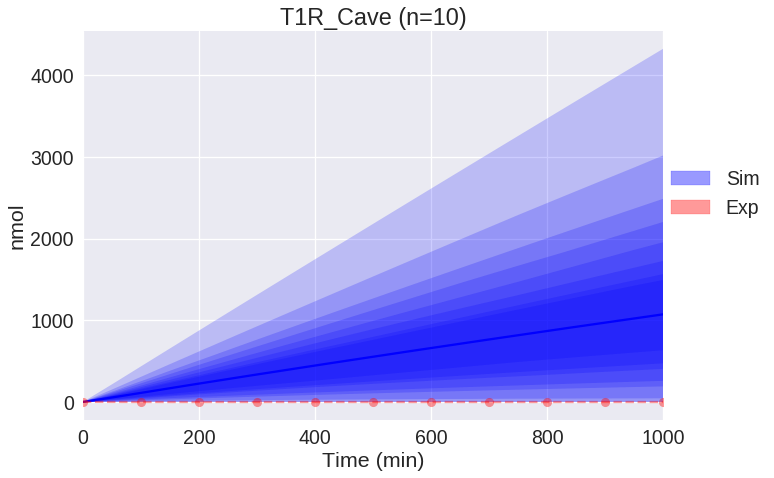

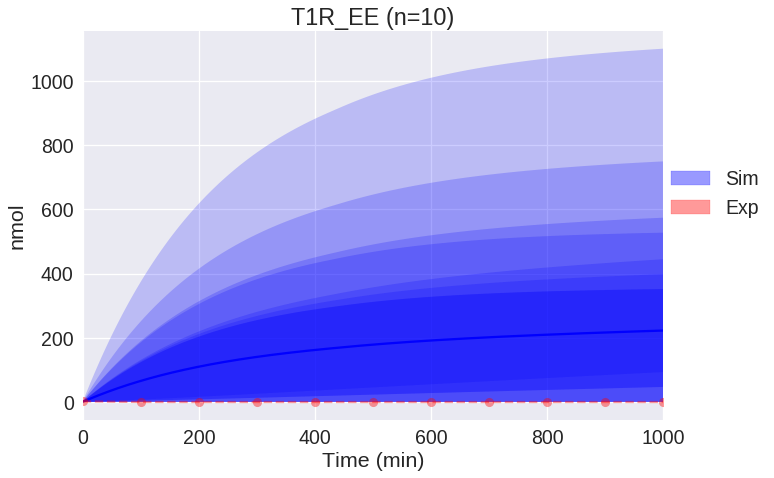

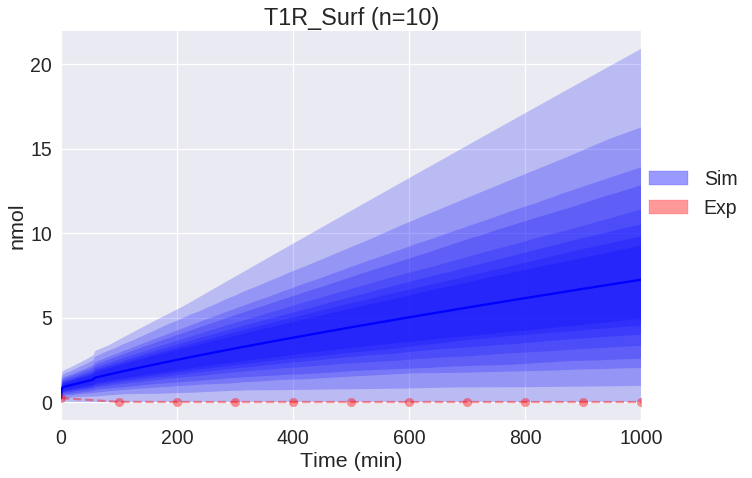

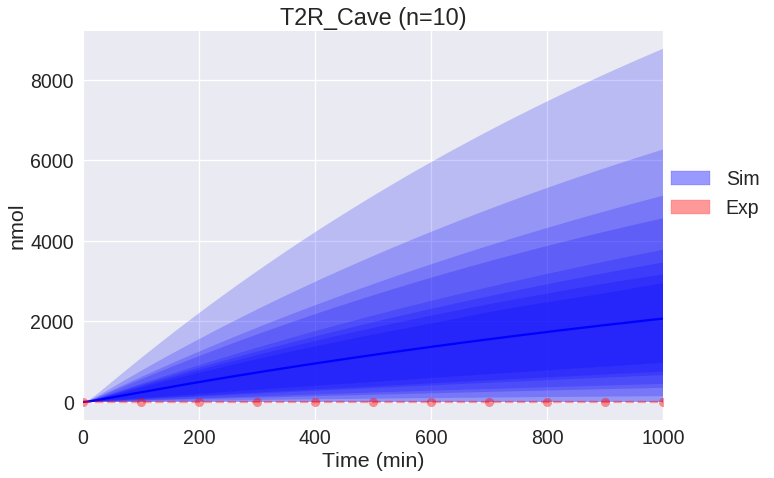

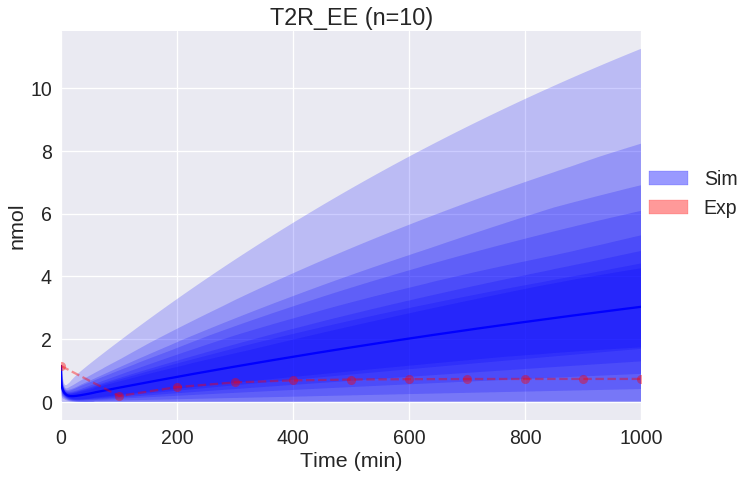

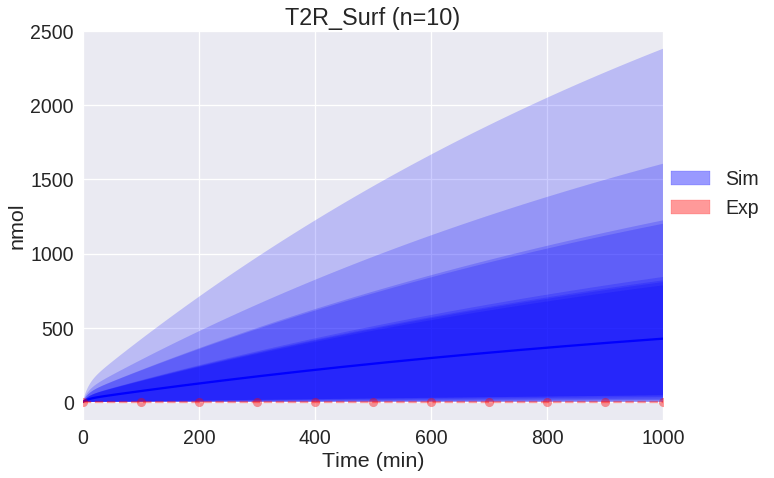

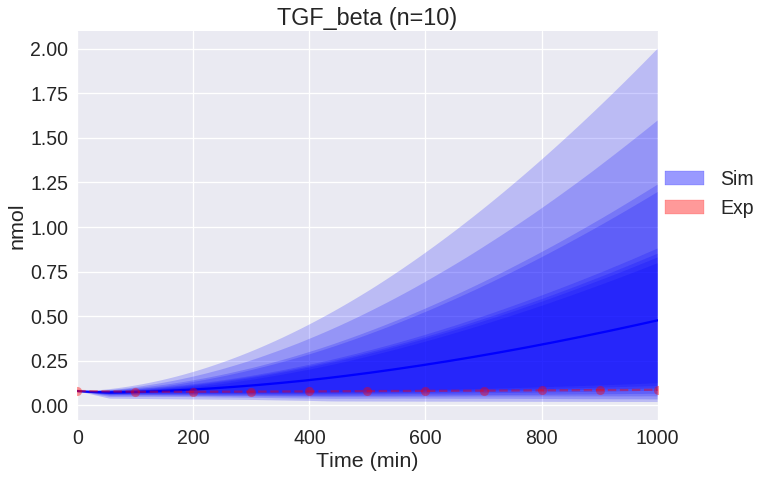

In [20]:
profiles = ['LRC_Cave', 'LRC_EE', 'LRC_Surf', 
            'Smad3c', 'Smad3n', 'Smad4c', 'Smad4n', 
            'Smads_Complex_c', 'Smads_Complex_n', 
            'T1R_Cave', 'T1R_EE', 'T1R_Surf', 
            'T2R_Cave', 'T2R_EE', 'T2R_Surf', 'TGF_beta']
viz.PlotTimeCourseEnsemble(
    ## take a MultiParameterEstimation class as arg
    MPE, 
    
    ## Here we choose top 10 ranking parameter sets to visualize
    truncate_mode='ranks', 
    theta=range(10), 
    
    ## choose our profiles. Defaults to all if no arg given
    y=profiles, 
    
    # choose confidence level. Defaults to 95 but can also be a list
    ci=[50, 60, 70, 80, 90, 95, 99, 100], 
    
    #Larger number of resamples --> More accurate estimates
    n_boot=10000, 
          
)

## Boxplots

In [ ]:
viz.Boxplot(MPE)

## Histograms

In [ ]:
viz.Histograms(MPE)

In [ ]:
f = '/home/b3053674/Documents/pycotools/ZiModel/data.csv'
f2 = '/home/b3053674/Documents/pycotools/ZiModel/data2.csv'

df = pandas.read_csv(f)
# df = df.drop(u'Unnamed: 0')
df = df.sort_values(by=['Time', 'ParameterFitIndex'])
# import seaborn
df.to_csv(f2)
# seaborn.tsplot(df, time='Time',value='Smad3c', unit='ParameterFitIndex')

In [ ]:
gammas = seaborn.load_dataset("gammas").head()

In [ ]:
ax = sns.tsplot(time="timepoint", value="BOLD signal",
                unit="subject", condition="ROI",
                data=gammas)

To monitor progress, look either at the task manager or system monitor. 